In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
import optuna

# Set random seeds for reproducibility
RANDOM_SEED = 50
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
class DiamondPriceMLP(nn.Module):
    """
    Multi-Layer Perceptron for Diamond Price Prediction
    
    Architecture:
    - Input layer (n_features)
    - Multiple hidden layers with ReLU, BatchNorm, and Dropout
    - Output layer (1 neuron for regression)
    """
    
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3, use_batch_norm=True, target_mean=None):
        super(DiamondPriceMLP, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        layers = []
        
        # Input to first hidden layer
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            # Linear layer
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Batch normalization (optional)
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Activation
            layers.append(nn.ReLU())
            
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        # Output layer (no activation for regression)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights(target_mean)
    
    def _initialize_weights(self, target_mean):
        """Initialize network weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if target_mean is not None:
            # self.network[-1] is the final Linear(prev_dim, 1) layer
            nn.init.constant_(self.network[-1].bias, target_mean)
    
    def forward(self, x):
        return self.network(x).squeeze()  # Remove extra dimension

In [5]:
# Get the current working directory (for Jupyter Notebooks)
script_dir = os.getcwd()

# Get the parent directory (the "father" folder)
parent_dir = os.path.dirname(script_dir)

# Define the path to the preprocessed data directory relative to the script's location
data_dir = os.path.join(parent_dir, 'data')

# Define the path to the models directory relative to the parent directory of the script's location
models_dir = os.path.join(parent_dir, 'models')

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

In [6]:
# Load the preprocessed data
X_train = np.load(f'{data_dir}/X_train_final.npy')
X_val = np.load(f'{data_dir}/X_val_final.npy')
X_test = np.load(f'{data_dir}/X_test_final.npy')

y_train_log = np.load(f'{data_dir}/y_train_log.npy')  # Log-transformed version!
y_val_log = np.load(f'{data_dir}/y_val_log.npy')
y_test_log = np.load(f'{data_dir}/y_test_log.npy')

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_log_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_val_log_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)
y_test_log_tensor = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

# Create Dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_log_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_log_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_log_tensor)

# Create DataLoader objects
batch_size = 128  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Overfitting a single batch

epoch: 0 loss: 58.66999816894531
epoch: 5 loss: 1.9145009517669678
epoch: 10 loss: 2.584200859069824
epoch: 15 loss: 1.3101396560668945
epoch: 20 loss: 1.456221580505371
epoch: 25 loss: 0.8156362175941467
epoch: 30 loss: 0.15235288441181183
epoch: 35 loss: 0.13118036091327667
epoch: 40 loss: 0.15266026556491852
epoch: 45 loss: 0.11252480000257492
epoch: 50 loss: 0.06323747336864471
epoch: 55 loss: 0.038322318345308304
epoch: 60 loss: 0.01913994923233986
epoch: 65 loss: 0.011519674211740494
epoch: 70 loss: 0.011305113323032856
epoch: 75 loss: 0.008643333800137043
epoch: 80 loss: 0.007558672688901424
epoch: 85 loss: 0.006922618485987186
epoch: 90 loss: 0.005766897927969694
epoch: 95 loss: 0.00515733053907752
epoch: 100 loss: 0.004614813718944788
epoch: 105 loss: 0.004135889932513237
epoch: 110 loss: 0.003715154714882374
epoch: 115 loss: 0.0033468480687588453
epoch: 120 loss: 0.002973712282255292
epoch: 125 loss: 0.0026540185790508986
epoch: 130 loss: 0.0023432776797562838
epoch: 135 loss

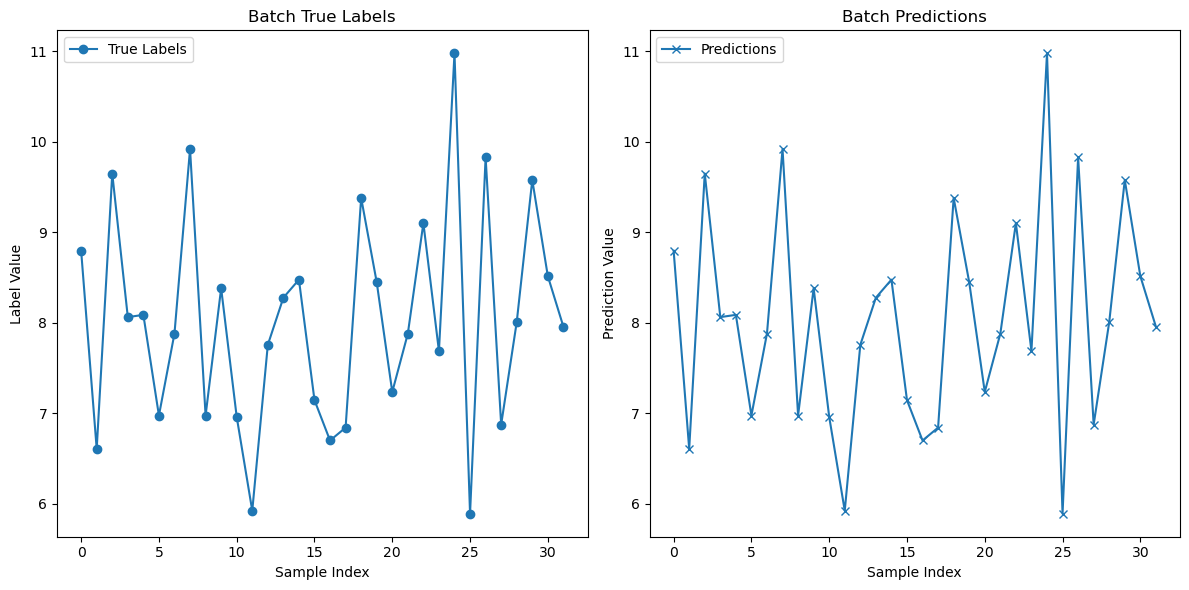

In [10]:
# Overfit a single batch for debugging

# Create DataLoader objects
batch_size = 32  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get a single batch to overfit
single_batch = next(iter(train_loader))
features, targets = single_batch
features = features.to(device)
targets = targets.to(device)

# define hyper-parmeters and create our model
num_features = 52
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 2000
# loss criterion
criterion = nn.MSELoss()
# model
model = DiamondPriceMLP(num_features, [128, 64, 32, 16], 0, False).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop for the model
for epoch in range(num_epochs):
    model.train()  # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
    epoch_losses = []
    
    # send data to device
    features = features.to(device)
    targets = targets.to(device)
    
    # forward pass
    output = model(features)  # calls model.forward(features)
    # loss
    loss = criterion(output.view(-1), targets.view(-1))
    # backward pass
    optimizer.zero_grad()  # clean the gradients from previous iteration, clears the `tensor.grad` field (tensor.grad=0)
    loss.backward()  # autograd backward to calculate gradients, assigns the `tensor.grad` field (e.g., tensor.grad=0.27)
    optimizer.step()  # apply update to the weights, applies the gradient update rule of the optimizer (param=param - lr * grad)
    
    epoch_losses.append(loss.item())
    
    # Store batch data for visualization
    if epoch == num_epochs - 1:  # Only store in the first epoch
        batch_features = features.cpu().numpy()
        batch_targets = targets.cpu().numpy()
        batch_predictions = output.detach().cpu().numpy()
    """
    if epoch == 500 or epoch == 1000 or epoch == 1500:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1  # Reduce by 10x
            print(f"Learning rate reduced to: {param_group['lr']}")
    """
    if epoch % 5 == 0:
        print(f'epoch: {epoch} loss: {np.mean(epoch_losses)}')

# Visualization
plt.figure(figsize=(12, 6))

# Plot true labels
plt.subplot(1, 2, 1)
plt.plot(batch_targets, label='True Labels', marker='o')
plt.title('Batch True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.plot(batch_predictions, label='Predictions', marker='x')
plt.title('Batch Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Value')
plt.legend()

plt.tight_layout()
plt.show()

# A regular run

In [11]:
# Create DataLoader objects
batch_size = 256  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# define hyper-parmeters and create our model
num_features = 52
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 500
# train loss criterion
train_criterion = nn.HuberLoss(delta=0.2)
# validtion loss criterion
val_criterion = nn.MSELoss()
# model
model = DiamondPriceMLP(num_features, [512, 256, 256, 128, 128, 64, 32], 0.1, False, target_mean=np.mean(y_train_log)).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# schedular

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Minimize val loss
    factor=0.5,        # Multiply LR by 0.5 when triggered
    patience=40,       # Wait 20 epochs before reducing
)

In [19]:
# training loop for the model
loss_history = []
for epoch in range(num_epochs):
    model.train()  # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
    train_losses = []
    
    for features, targets in train_loader:
        # send data to device
        features = features.to(device)
        targets = targets.to(device)
        
        # forward pass
        output = model(features)  # calls model.forward(features)
        # loss
        loss = train_criterion(output.view(-1), targets.view(-1))
        # backward pass
        optimizer.zero_grad()  # clean the gradients from previous iteration, clears the `tensor.grad` field (tensor.grad=0)
        loss.backward()  # autograd backward to calculate gradients, assigns the `tensor.grad` field (e.g., tensor.grad=0.27)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ← Gradient clipping
        optimizer.step()  # apply update to the weights, applies the gradient update rule of the optimizer (param=param - lr * grad)
        
        train_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    val_real_losses = []  # ← Better name
    val_mapes = []        # ← New list to store MAPE values
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)
            output = model(features)

            loss = val_criterion(output.view(-1), targets.view(-1))
            val_losses.append(loss.item())

            real_output = torch.expm1(output)      # ← Changed from exp() to expm1()
            real_targets = torch.expm1(targets)    # ← Changed from exp() to expm1()
            real_loss = val_criterion(real_output.view(-1), real_targets.view(-1))
            val_real_losses.append(real_loss.item())

            abs_percentage_error = torch.abs((real_targets - real_output) / (real_targets + 1e-8))
            batch_mape = torch.mean(abs_percentage_error) * 100
            val_mapes.append(batch_mape.item())            
    
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_real_loss  = np.mean(val_real_losses)
        val_real_rmse = np.sqrt(val_real_loss)
        val_mape = np.mean(val_mapes)  # <--- Average MAPE for the epoch
        scheduler.step(val_real_rmse)
        loss_history.append((train_loss, val_loss, val_real_loss))

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}, '
              f'Val Loss (log) = {val_loss:.6f}, '
              f'Val RMSE (real $) = ${val_real_rmse:,.2f}, '
              f'Val MAPE = {val_mape:.2f}%, '
              f'LR={scheduler.get_last_lr()}')

Epoch 0: Train Loss = 0.014876, Val Loss (log) = 0.054759, Val RMSE (real $) = $4,277.62, Val MAPE = 217.51%, LR=[7.8125e-05]
Epoch 5: Train Loss = 0.014928, Val Loss (log) = 0.055377, Val RMSE (real $) = $4,304.92, Val MAPE = 216.50%, LR=[7.8125e-05]
Epoch 10: Train Loss = 0.014889, Val Loss (log) = 0.053992, Val RMSE (real $) = $4,244.84, Val MAPE = 218.30%, LR=[7.8125e-05]
Epoch 15: Train Loss = 0.014868, Val Loss (log) = 0.054864, Val RMSE (real $) = $4,272.07, Val MAPE = 217.56%, LR=[7.8125e-05]
Epoch 20: Train Loss = 0.014895, Val Loss (log) = 0.053994, Val RMSE (real $) = $4,231.90, Val MAPE = 218.31%, LR=[3.90625e-05]
Epoch 25: Train Loss = 0.014856, Val Loss (log) = 0.053788, Val RMSE (real $) = $4,214.17, Val MAPE = 218.61%, LR=[3.90625e-05]
Epoch 30: Train Loss = 0.014877, Val Loss (log) = 0.053155, Val RMSE (real $) = $4,193.27, Val MAPE = 219.21%, LR=[3.90625e-05]
Epoch 35: Train Loss = 0.014894, Val Loss (log) = 0.053274, Val RMSE (real $) = $4,192.95, Val MAPE = 219.22%,

# Basib Optuna Test

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
import optuna

# Set random seeds for reproducibility
RANDOM_SEED = 50
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
class DiamondPriceMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3, use_batch_norm=True, target_mean=None):
        super(DiamondPriceMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
        
        self._initialize_weights(target_mean)
    
    def _initialize_weights(self, target_mean):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if target_mean is not None:
            nn.init.constant_(self.network[-1].bias, target_mean)
    
    def forward(self, x):
        return self.network(x).squeeze()

In [4]:
X_train = np.load('data/X_train_final.npy')
y_train_log = np.load('data/y_train_log.npy')
X_val = np.load('data/X_val_final.npy')
y_val_log = np.load('data/y_val_log.npy')

def train_model(trial, X_train, y_train, X_val, y_val, device, 
                n_epochs=300, early_stopping_patience=40, early_stopping=False):
    """
    Train model with hyperparameters suggested by Optuna
    
    Returns validation RMSE (lower is better)
    """
    
    # ========================================================================
    # HYPERPARAMETERS TO TUNE
    # ========================================================================
    
    # 1. Architecture
    '''
    n_layers = trial.suggest_int('n_layers', 3, 6)
    hidden_dims = []
    current_dim = trial.suggest_categorical('start_units', [1024, 256, 512])

    for i in range(n_layers):
        # FIX: Suggest a 'shrink' decision (0 = same size, 1 = half size)
        # The choices [0, 1] are now STATIC, so Optuna stays happy.
        should_shrink = trial.suggest_categorical(f'shrink_layer_{i}', [0, 1])
        
        if should_shrink == 1 and current_dim > 64: # Safety floor
            current_dim = current_dim // 2
            
        hidden_dims.append(current_dim)
    '''
    hidden_dims = [512, 256, 256, 128, 128, 64, 32]
    
    # 2. Regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # 3. Learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # 4. Batch size
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    
    # ========================================================================
    # CREATE MODEL AND OPTIMIZER
    # ========================================================================
    
    model = DiamondPriceMLP(
        input_dim=X_train.shape[1],
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm,
        target_mean=np.mean(y_train_log)
    ).to(device)
    

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )

    train_criterion = nn.HuberLoss(delta=trial.suggest_float('huber_delta', 0.05, 1.0))
    val_criterion = nn.MSELoss()
    
    # Create dataloaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # ========================================================================
    # TRAINING LOOP
    # ========================================================================
    
    best_val_rmse = float('inf')
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            
            output = model(features)
            loss = train_criterion(output.view(-1), targets.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ← Gradient clipping
            
            optimizer.step()
        
        # Validate
        model.eval()
        val_losses = []
        val_real_losses = []
        
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.to(device)
                
                output = model(features)
                loss = val_criterion(output.view(-1), targets.view(-1))
                val_losses.append(loss.item())

                real_output = torch.expm1(output)      # ← Changed from exp() to expm1()
                real_targets = torch.expm1(targets)    # ← Changed from exp() to expm1()
                real_loss = val_criterion(real_output.view(-1), real_targets.view(-1))
                val_real_losses.append(real_loss.item())   
        
        val_loss = np.mean(val_losses)
        val_real_loss  = np.mean(val_real_losses)
        val_real_rmse = np.sqrt(val_real_loss)
        
        if val_real_rmse < best_val_rmse:
                    best_val_rmse = val_real_rmse
                    patience_counter = 0
                    # Optional: Save best model state here
        else:
            patience_counter += 1

        # Report intermediate value for pruning
        trial.report(val_real_rmse, epoch)
        
        if early_stopping and patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # ========================================================================
    # FINAL EVALUATION (Real RMSE)
    # ========================================================================
    
    model.eval()
    total_real_mse = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)
            
            # 1. Get model log-predictions
            output_log = model(features).view(-1)
            targets_log = targets.view(-1)
            
            # 2. Transform BOTH to real prices ($)
            # We do this before the criterion to calculate RMSE in dollars
            output_real = torch.expm1(output_log)
            targets_real = torch.expm1(targets_log)
            
            # 3. Calculate MSE for this batch in real dollars
            # val_criterion is nn.MSELoss()
            batch_mse = val_criterion(output_real, targets_real)
            
            # 4. Accumulate weighted by batch size (handles smaller last batches)
            batch_size = features.size(0)
            total_real_mse += batch_mse.item() * batch_size
            total_samples += batch_size

    # 5. Final RMSE calculation
    final_real_mse = total_real_mse / total_samples
    rmse = np.sqrt(final_real_mse)
    
    return rmse

In [6]:

def objective(trial):
    """
    Objective function for Optuna to minimize
    """
    
    # Load data
    print(f"\nTrial {trial.number}: Testing hyperparameters...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Train and evaluate
    try:
        rmse = train_model(trial, X_train, y_train_log, X_val, y_val_log, device, early_stopping=False)
        
        # Check for invalid values
        if np.isnan(rmse) or np.isinf(rmse):
            rmse = 1e10 # Large penalty
    
    except Exception as e:
            print(f"Trial failed due to: {e}")
            rmse = 1e10
  
    print(f"  → Validation RMSE: ${rmse:,.0f}")
    
    return rmse

In [7]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(study_name="diamond-mlp", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-09 18:32:32,766] A new study created in memory with name: diamond-mlp


  0%|          | 0/100 [00:00<?, ?it/s]


Trial 0: Testing hyperparameters...
  → Validation RMSE: $16,179
[I 2026-01-09 18:43:02,637] Trial 0 finished with value: 16178.738402700143 and parameters: {'dropout_rate': 0.18727005942368125, 'weight_decay': 0.0007114476009343421, 'use_batch_norm': True, 'learning_rate': 2.9380279387035334e-05, 'batch_size': 512, 'huber_delta': 0.6210592611560484}. Best is trial 0 with value: 16178.738402700143.

Trial 1: Testing hyperparameters...
  → Validation RMSE: $13,949
[I 2026-01-09 18:53:14,191] Trial 1 finished with value: 13948.712216055088 and parameters: {'dropout_rate': 0.35403628889802274, 'weight_decay': 1.1527987128232402e-06, 'use_batch_norm': True, 'learning_rate': 4.335281794951564e-05, 'batch_size': 512, 'huber_delta': 0.548518610050626}. Best is trial 1 with value: 13948.712216055088.

Trial 2: Testing hyperparameters...
  → Validation RMSE: $16,781
[I 2026-01-09 19:03:26,113] Trial 2 finished with value: 16780.903279089085 and parameters: {'dropout_rate': 0.21597250932105788,

KeyboardInterrupt: 